# Main functions

In [ ]:
from __future__ import print_function
from IPython.display import clear_output
import torch
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
from time import time
from random import choice
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.spatial import Delaunay
from copy import copy
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#from queue import Queue

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_hull_fw(G, FW, s):
    side = set(copy(s))
    new = {1}
    
    while len(new) != 0:
        new = set()
        for start, finish in list(combinations(side, 2)):
            for node in set(G.nodes()) - side:
                if FW[start, finish] > 1 and FW[start, node] + FW[node, finish] == FW[start, finish]:
                    new.add(node)
                    #print(node, start, finish)
        #print(new)
        side = side.union(new)
    return list(side)

In [ ]:
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).todense()

FW = nx.floyd_warshall_numpy(G)
GFW = nx.convert_matrix.from_numpy_matrix(FW)

In [ ]:
def in_hull_l1(p, simplex_min, simplex_max):
    K = len(simplex_min)
    for d in range(K):
        if (p[d] < simplex_min[d]) or (p[d] > simplex_max[d]):
            return False
    return True

In [ ]:
def get_from_hull(emb, hull):
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    n = emb.shape[0]
    res = []
    for i in range(n):
        if hull.find_simplex(emb[i])>=0:
            res.append(i)
    return res

In [ ]:
def get_from_hull_l1(emb, base):
    K = emb.shape[1]
    simplex_min = np.ones(K) * emb[base[0]]
    simplex_max = np.ones(K) * emb[base[0]]
    for d in range(K):
        for i in range(len(base)):
            if emb[base[i], d] < simplex_min[d]:
                simplex_min[d] = emb[base[i], d]
            if emb[base[i], d] > simplex_max[d]:
                simplex_max[d] = emb[base[i], d]

    res = []
    for i in range(emb.shape[0]):
        if in_hull_l1(emb[i], simplex_min, simplex_max):
            res.append(i)
    return res

In [ ]:
def comparison_score(s1, s2):
    return len(set(s1).intersection(set(s2))) / len(set(s1).union(set(s2)))

In [ ]:
def projection_score(h_graph, h_space):
    # h_graph and h_space need to be sorted!

    h_graph.sort()
    h_space.sort()
    s = len(h_space)
    err = 0
    s_itr = 0
    for g_itr in range(len(h_graph)):
        while s_itr < len(h_space) and h_space[s_itr] < h_graph[g_itr]:
            err += 1
            s_itr += 1
        s_itr += 1

    return (s - err) / s

In [ ]:
def test_comparison_l1(emb, G, n_itr, n_base, log=True, debug=False):
    np.random.seed(42)
    FW = nx.floyd_warshall_numpy(G)
    mean_score = 0
    i = 0
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        h_space = get_from_hull_l1(emb, base)
        s = comparison_score(h_space, h_graph)
        if debug:
            print(base)
            print(h_space)
            print(h_graph)
        if log:
            print(s)
        mean_score += s
        i += 1
    mean_score /= n_itr
    return mean_score

In [ ]:
def test_comparison_time(emb, G, n_itr, n_base, log=True):
    np.random.seed(42)
    mean_score = 0
    i = 0
    g_time = []
    s_time = []
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)

        try:
            s_start = time()
            h = Delaunay(emb[base].tolist())
            h_space = get_from_hull(emb, h)
            s_end = time()
            s_time.append(s_end - s_start)

            g_start = time()
            h_graph = get_hull_fw(G, FW, base)
            g_end = time()
            g_time.append(g_end - g_start)

            s = comparison_score(h_space, h_graph)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Delaunay error')
    mean_score /= n_itr
    return mean_score, g_time, s_time

In [ ]:
def test_comparison_l1_time(emb, G, n_itr, n_base, log=True, debug=False):
    np.random.seed(42)
    FW = nx.floyd_warshall_numpy(G)
    mean_score = 0
    i = 0
    g_time = []
    s_time = []
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)

        g_start = time()
        h_graph = get_hull_fw(G, FW, base)
        g_end = time()
        g_time.append(g_end - g_start)

        s_start = time()
        h_space = get_from_hull_l1(emb, base)
        s_end = time()
        s_time.append(s_end - s_start)

        s = comparison_score(h_space, h_graph)
        if debug:
            print(base)
            print(h_space)
            print(h_graph)
        if log:
            print(s)
        mean_score += s
        i += 1
    mean_score /= n_itr
    return mean_score, g_time, s_time

In [ ]:
def test_projection_l1(emb, G, n_itr, n_base, log=True):
    np.random.seed(42)
    FW = nx.floyd_warshall_numpy(G)
    mean_score = 0
    i = 0
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        try:
            h_space = get_from_hull_l1(emb, h_graph)
            s = projection_score(h_graph, h_space)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Delaunay error')
    mean_score /= n_itr
    return mean_score

In [ ]:
def distdec_l1(u, v):
    return  torch.dist(u, v, p=1)

In [ ]:
def distance_matrix_l1(emb):
    n = emb.shape[0]
    D = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            D[i, j] = np.linalg.norm(emb[i] - emb[j], ord=1)
    return D

# Graph Convolutional Networks

## Implementation

In [ ]:
print(torch.__version__)

1.9.0+cu102


In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 4.2MB/s 
     |████████████████████████████████| 1.4MB 4.0MB/s 
     |████████████████████████████████| 225kB 4.3MB/s 
     |████████████████████████████████| 235kB 7.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 


In [ ]:
from torch_geometric.datasets import KarateClub
from torch.nn import Linear, ModuleList
from torch_geometric.nn import GCNConv
import torch_geometric

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, h_sizes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv = ModuleList()
        self.conv.append(GCNConv(data.num_features, h_sizes[0]))
        for i in range(1, len(h_sizes)):
            self.conv.append(GCNConv(h_sizes[i-1], h_sizes[i]))

    def forward(self, x, edge_index):
        h = self.conv[0](x, edge_index)
        for i in range(1, len(self.conv)):
            h = h.relu()
            h = self.conv[i](h, edge_index)

        return h

In [ ]:
def loss_euclidean(X, A, norm=1):
    dist = torch.cdist(X, X, p=norm)
    k = dist.shape[0]**2 - dist.shape[0]
    s = torch.sum((dist - A)**2) / k
    return s

In [ ]:
def gcn_train(data):
    optimizer.zero_grad()
    emb = model(data.x, data.edge_index)
    loss = loss_euclidean(emb, torch.tensor(FW / np.max(FW)), norm=2)
    loss.backward()
    optimizer.step()
    return loss, emb

In [ ]:
def gcn_train_l1(data):
    optimizer.zero_grad()
    emb = model(data.x, data.edge_index)
    loss = loss_euclidean(emb, torch.tensor(FW / np.max(FW)), norm=1)
    loss.backward()
    optimizer.step()
    return loss, emb

In [ ]:
def custom_data(G):
    data = torch_geometric.utils.from_networkx(G)
    data.x = torch.eye(len(G))
    return data

In [ ]:
def discretize(emb, decimals):
    return np.around(emb, decimals=decimals)

## One Layer

In [ ]:
data = custom_data(G)
FW = nx.floyd_warshall_numpy(G)

In [ ]:
np.max([d for node, d in G.degree()])

17

In [ ]:
model = GCN([8])
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
for epoch in range(2000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0963, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0103, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0058, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0035, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0027, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0021, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0019, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0017, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0016, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0015, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0014, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0014, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0014, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0013, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0013, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0013, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, G, 50, 4, log=False))

Comparison score: 0.3206709432264689


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, G, 50, 4, log=False))

Comparison score: 0.5823571268324264
Comparison score: 0.37155303180838245
Comparison score: 0.3270569081387496
Comparison score: 0.3206709432264689
Comparison score: 0.3206709432264689
Comparison score: 0.3206709432264689


In [ ]:
print('Projection score:', test_projection_l1(emb, G, 50, 4, log=False))

Projection score: 0.932


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, G, 50, 4, log=False))

Projection score: 0.92939010989011
Projection score: 0.9343333333333332
Projection score: 0.929
Projection score: 0.932
Projection score: 0.932
Projection score: 0.932


## Three layers

In [ ]:
data = custom_data(G)
FW = nx.floyd_warshall_numpy(G)

In [ ]:
model = GCN([21, 14, 7])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2025, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1411, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0872, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0559, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0446, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0387, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0356, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0337, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0322, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0309, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0298, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0289, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0282, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0276, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0272, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0267, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, G, 50, 4, log=False))

Comparison score: 0.3529060819529256


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, G, 50, 4, log=False))

Comparison score: 0.6083130206940275
Comparison score: 0.41763738882974316
Comparison score: 0.37154882517461607
Comparison score: 0.35905759710444074
Comparison score: 0.3529060819529256
Comparison score: 0.3529060819529256


In [ ]:
print('Projection score:', test_projection_l1(emb, G, 50, 4, log=False))

Projection score: 0.9713643149375413


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, G, 50, 4, log=False))

Projection score: 0.7944632947318101
Projection score: 0.9624071720803983
Projection score: 0.9713643149375413
Projection score: 0.9713643149375413
Projection score: 0.9713643149375413
Projection score: 0.9713643149375413


## Enron email network

In [ ]:
from google.colab import files
files.upload()

Saving email-enron-only.mtx to email-enron-only (2).mtx


{'email-enron-only.mtx': b'17 1\n72 1\n3 2\n19 2\n20 2\n27 2\n29 2\n31 2\n48 2\n65 2\n67 2\n69 2\n71 2\n132 2\n136 2\n4 3\n19 3\n20 3\n28 3\n31 3\n65 3\n67 3\n69 3\n71 3\n132 3\n136 3\n19 4\n20 4\n27 4\n29 4\n31 4\n54 4\n69 4\n71 4\n132 4\n136 4\n22 5\n72 5\n9 6\n13 6\n16 6\n26 6\n47 6\n49 6\n64 6\n66 6\n105 6\n11 7\n12 7\n24 7\n74 7\n75 7\n112 8\n124 8\n13 9\n47 9\n49 9\n51 9\n56 9\n66 9\n74 9\n75 9\n78 9\n91 9\n139 9\n17 10\n21 10\n37 10\n53 10\n70 10\n72 10\n122 10\n124 10\n12 11\n17 11\n32 11\n37 11\n74 11\n124 11\n137 11\n32 12\n37 12\n74 12\n75 12\n26 13\n32 13\n47 13\n49 13\n56 13\n66 13\n75 13\n105 13\n139 13\n16 14\n22 14\n26 14\n50 14\n64 14\n68 14\n72 14\n73 14\n132 14\n85 15\n26 16\n47 16\n50 16\n64 16\n73 16\n105 16\n107 16\n122 16\n21 17\n24 17\n25 17\n32 17\n36 17\n37 17\n39 17\n40 17\n41 17\n43 17\n48 17\n55 17\n58 17\n60 17\n61 17\n70 17\n76 17\n82 17\n95 17\n101 17\n104 17\n105 17\n115 17\n121 17\n122 17\n124 17\n128 17\n19 18\n20 18\n27 18\n29 18\n31 18\n48 18\n65 18

In [ ]:
G = nx.read_edgelist("/content/email-enron-only.mtx", nodetype=int, data=False)

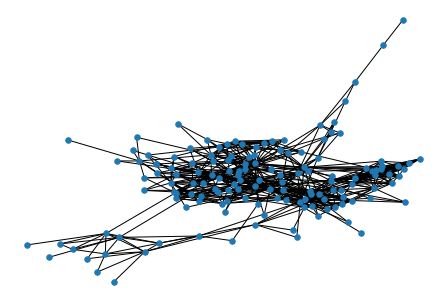

In [ ]:
nx.draw(G, node_size=30)

In [ ]:
nx.number_of_nodes(G)

143

In [ ]:
nx.number_of_edges(G)

623

In [ ]:
nx.diameter(G)

8

In [ ]:
mapping = {}
for i in G.nodes():
    mapping[i] = i - 1

In [ ]:
nx.relabel_nodes(G, mapping, copy=False)

In [ ]:
data = custom_data(G)
FW = nx.floyd_warshall_numpy(G)

In [ ]:
model = GCN([25, 20, 15])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0949, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0334, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0224, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0171, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0155, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0136, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0125, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0117, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0110, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0103, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0097, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0093, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0090, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0086, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0084, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0081, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
g_bar = np.empty((2, 25))
l1_bar = np.empty((2, 25))
scores = []
for base in range(4, 29):
    score, g_time, s_time = test_comparison_l1_time(emb, G, 10, base, log=False)
    g_bar[0, base - 4] = np.mean(g_time)
    g_bar[1, base - 4] = np.std(g_time)
    scores.append(score)
    l1_bar[0, base - 4] = np.mean(s_time)
    l1_bar[1, base - 4] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.36260446703551424
Std: 0.18551631234103624


In [ ]:
model = GCN([10, 6, 3])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1395, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1227, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.1029, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0820, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0630, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0494, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0423, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0391, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0369, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0350, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0332, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0315, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0300, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0289, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0280, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0272, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
l2_bar = np.empty((2, 25))
scores = []
for base in range(4, 29):
    score, g_time, s_time = test_comparison_time(emb, G, 10, base, log=False)
    scores.append(score)
    l2_bar[0, base - 4] = np.mean(s_time)
    l2_bar[1, base - 4] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.41543536379689705
Std: 0.17501655983264014


In [ ]:
model = GCN([25, 20, 15])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1337, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1019, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0654, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0348, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0240, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0217, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0190, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0179, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0168, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0160, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0153, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0145, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0138, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0132, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0127, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0124, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
l2_15_bar = np.empty((2, 13))
scores = []
for base in range(16, 29):
    score, g_time, s_time = test_comparison_time(emb, G, 10, base, log=False)
    scores.append(score)
    l2_15_bar[0, base - 16] = np.mean(s_time)
    l2_15_bar[1, base - 16] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.13488933416005533
Std: 0.026440750789304836


In [ ]:
model = GCN([10, 6, 3])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1315, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1087, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0846, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0632, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0487, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0418, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0383, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0355, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0329, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0311, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0297, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0284, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0271, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0260, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0250, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0242, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
l1_3_bar = np.empty((2, 25))
scores = []
for base in range(4, 29):
    score, g_time, s_time = test_comparison_l1_time(emb, G, 10, base, log=False)
    scores.append(score)
    l1_3_bar[0, base - 4] = np.mean(s_time)
    l1_3_bar[1, base - 4] = np.std(s_time)

In [ ]:
print('Mean:', np.mean(scores))
print('Std:', np.std(scores))

Mean: 0.6548414471005879
Std: 0.16725705590978635


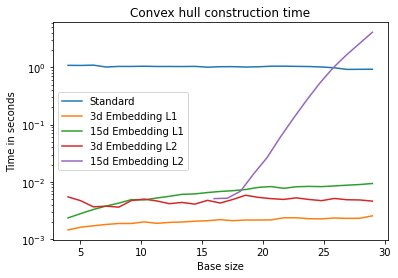

In [ ]:
plt.plot(np.linspace(4, 29, 25), g_bar[0, :], label='Standard')
plt.plot(np.linspace(4, 29, 25), l1_3_bar[0, :], label='3d Embedding L1')
plt.plot(np.linspace(4, 29, 25), l1_bar[0, :], label='15d Embedding L1')
plt.plot(np.linspace(4, 29, 25), l2_bar[0, :], label='3d Embedding L2')
plt.plot(np.linspace(16, 29, 13), l2_15_bar[0, :], label='15d Embedding L2')
plt.yscale("log")
plt.title("Convex hull construction time")
plt.legend()
plt.xlabel('Base size')
plt.ylabel('Time in seconds')
plt.show()

# Communities

## Implementation

In [ ]:
import community as co

In [ ]:
def labels_from_partition(part):
    labels = {}
    for i in range(len(part)):
        if part[i] not in labels:
            labels[part[i]] = [i]
        else:
            labels[part[i]].append(i)
    return labels

In [ ]:
def graph_community(G, labels, community):
    SG = nx.subgraph(G, labels[community]).copy()
    idx = {}
    i = 0
    for v in SG.nodes():
        idx[v] = i
        i += 1
    SG = nx.relabel_nodes(SG, idx)
    return SG

In [ ]:
def test_comparison_community(emb, G, n_itr, n_base, labels, ext=False, log=True, debug=False):
    np.random.seed(42)
    mean_score = 0
    i = 0
    while i < n_itr:
        if ext == False:
            community = np.random.randint(0, len(labels))
            base = np.random.choice(labels[community], n_base, replace=False)
        else:
            #n_base_0 = np.random.choice(np.arange(1, n_base))
            #n_base_1 = n_base - n_base_0
            #base = np.random.choice(labels[0], n_base_0, replace=False)
            #base = np.append(base, np.random.choice(labels[1], n_base_1, replace=False))
            base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        h_space = get_from_hull_l1(emb, base)
        s = comparison_score(h_space, h_graph)
        if debug:
            print(base)
            print(h_space)
            print(h_graph)
        if log:
            print(s)
        mean_score += s
        i += 1
    mean_score /= n_itr
    return mean_score

## Karate Club

In [ ]:
part = []
for i in range(len(G)):
    if G.nodes[i]['club'] == 'Mr. Hi':
        part.append(0)
    else:
        part.append(1)

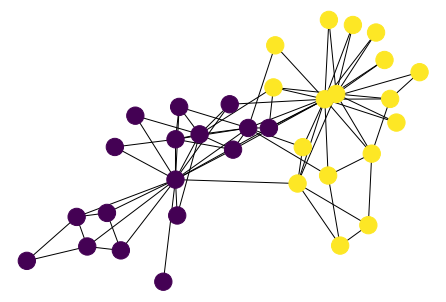

In [ ]:
nx.draw(G, node_color=part)

In [ ]:
labels = labels_from_partition(part)
labels

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 1: [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]}

In [ ]:
G0 = graph_community(G, labels, 0)
G1 = graph_community(G, labels, 1)

### Community 0

In [ ]:
data = custom_data(G0)
FW = nx.floyd_warshall_numpy(G0)

In [ ]:
model = GCN([21, 14, 7])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(7000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2230, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1509, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.1067, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0858, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0804, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0769, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0736, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0707, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0682, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0658, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0635, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0611, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0587, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0556, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0522, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0486, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, G0, 50, 2, log=False))

Comparison score: 0.7060000000000001


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, G0, 50, 2, log=False, debug=False))

Comparison score: 0.8393333333333334
Comparison score: 0.7140000000000001
Comparison score: 0.7060000000000001
Comparison score: 0.7060000000000001
Comparison score: 0.7060000000000001
Comparison score: 0.7060000000000001


### Community 1

In [ ]:
data = custom_data(G1)
FW = nx.floyd_warshall_numpy(G1)

In [ ]:
model = GCN([21, 14, 7])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(7000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.3068, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.2488, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.2066, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.1640, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.1265, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0956, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0786, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0734, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0705, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0676, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0646, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0618, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0592, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0566, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0537, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0511, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, G1, 50, 2, log=False))

Comparison score: 0.6500476190476191


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, G1, 50, 2, log=False, debug=False))

Comparison score: 0.8369047619047619
Comparison score: 0.6583809523809524
Comparison score: 0.6500476190476191
Comparison score: 0.6500476190476191
Comparison score: 0.6500476190476191
Comparison score: 0.6500476190476191


### Sampling

In [ ]:
data = custom_data(G)
FW = nx.floyd_warshall_numpy(G)

In [ ]:
model = GCN([21, 14, 7])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2025, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1411, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0872, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0559, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0446, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0387, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0356, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0337, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0322, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0309, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0298, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0289, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0282, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0276, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0272, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0267, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
# Sampling from both communities

print('Comparison score:', test_comparison_community(emb, G, 50, 4, labels, ext=True, log=False))

Comparison score: 0.3529060819529256


In [ ]:
print('Projection score:', test_projection_l1(emb, G, 50, 4, log=False))

Projection score: 0.9390000000000001


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_community(demb, G, 50, 4, labels, ext=True, log=False))

Comparison score: 0.6083130206940275
Comparison score: 0.41763738882974316
Comparison score: 0.37154882517461607
Comparison score: 0.35905759710444074
Comparison score: 0.3529060819529256
Comparison score: 0.3529060819529256


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, G, 50, 4, log=False))

Projection score: 0.8712502939956497
Projection score: 0.9430000000000001
Projection score: 0.9430000000000001
Projection score: 0.9430000000000001
Projection score: 0.9390000000000001
Projection score: 0.9390000000000001


In [ ]:
# Sampling within communities

print('Comparison score:', test_comparison_community(emb, G, 50, 4, labels, ext=False, log=False))

Comparison score: 0.5357939579340507


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_community(demb, G, 50, 4, labels, ext=False, log=False))

Comparison score: 0.5730330181514394
Comparison score: 0.577796869625043
Comparison score: 0.552327571379429
Comparison score: 0.5369050690451619
Comparison score: 0.5357939579340507
Comparison score: 0.5357939579340507


## Stochastic Block Model

### Implementation

In [ ]:
def block_model(n,p_in,p_out):
    A1=np.random.binomial(1, p_in, size=[n,n]) # for edges inside clusters
    A2=np.random.binomial(1, p_in, size=[n,n])
    for i in range(n):
        A1[i,i]=0
        A2[i,i]=0
        for j in range(i+1,n):
            A1[i,j]=A1[j,i]
            A2[i,j]=A2[j,i]
        
    B=np.random.binomial(1, p_out, size=[n,n]) # for edges between clusters
    A=np.block([[A1,B],[B,A2]])
    G=nx.from_numpy_matrix(A)
    return G

### SBM 50

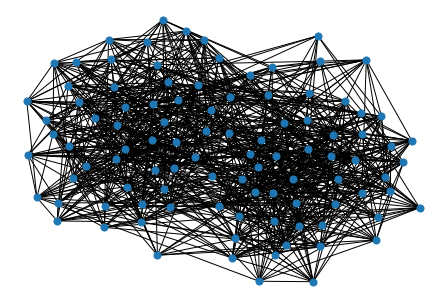

In [ ]:
n = 50
p_in = 0.3
p_out = 0.05

bG=block_model(n, p_in, p_out)
nx.draw(bG,node_size=50)

In [ ]:
data = custom_data(bG)
FW = nx.floyd_warshall_numpy(bG)

In [ ]:
nx.diameter(bG)

3

In [ ]:
part = [0] * n + [1] * n
labels = labels_from_partition(part)

In [ ]:
G0 = graph_community(bG, labels, 0)
G1 = graph_community(bG, labels, 1)

#### Full network

In [ ]:
model = GCN([20])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0268, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0228, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0203, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0186, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0173, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0163, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0155, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0148, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0142, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0138, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0134, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0130, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0127, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0124, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0122, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0119, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
# Sampling within communities

print('Comparison score:', test_comparison_community(emb, bG, 50, 4, labels, ext=False, log=False))

Comparison score: 0.040000000000000015


In [ ]:
# Sampling from both communities

print('Comparison score:', test_comparison_community(emb, bG, 50, 4, labels, ext=True, log=False))

Comparison score: 0.040000000000000015


#### Community 0

In [ ]:
data = custom_data(G0)
FW = nx.floyd_warshall_numpy(G0)

In [ ]:
model = GCN([20, 13])
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
for epoch in range(2000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2524, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0323, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0226, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0179, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0157, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0145, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0136, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0130, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0126, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0123, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0121, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0118, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0116, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0114, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0113, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0111, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, G0, 50, 2, log=False))

Comparison score: 0.4323999999999997


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, G0, 50, 2, log=False, debug=False))

Comparison score: 0.41266666666666646
Comparison score: 0.4323999999999997
Comparison score: 0.4323999999999997
Comparison score: 0.4323999999999997
Comparison score: 0.4323999999999997
Comparison score: 0.4323999999999997


#### Community 1

In [ ]:
data = custom_data(G1)
FW = nx.floyd_warshall_numpy(G1)

In [ ]:
model = GCN([20, 13])
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [ ]:
for epoch in range(2000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2522, grad_fn=<DivBackward0>)
10 tensor(0.0357, grad_fn=<DivBackward0>)
20 tensor(0.0202, grad_fn=<DivBackward0>)
30 tensor(0.0170, grad_fn=<DivBackward0>)
40 tensor(0.0150, grad_fn=<DivBackward0>)
50 tensor(0.0138, grad_fn=<DivBackward0>)
60 tensor(0.0130, grad_fn=<DivBackward0>)
70 tensor(0.0123, grad_fn=<DivBackward0>)
80 tensor(0.0119, grad_fn=<DivBackward0>)
90 tensor(0.0115, grad_fn=<DivBackward0>)
100 tensor(0.0113, grad_fn=<DivBackward0>)
110 tensor(0.0111, grad_fn=<DivBackward0>)
120 tensor(0.0109, grad_fn=<DivBackward0>)
130 tensor(0.0108, grad_fn=<DivBackward0>)
140 tensor(0.0107, grad_fn=<DivBackward0>)
150 tensor(0.0106, grad_fn=<DivBackward0>)
160 tensor(0.0105, grad_fn=<DivBackward0>)
170 tensor(0.0104, grad_fn=<DivBackward0>)
180 tensor(0.0103, grad_fn=<DivBackward0>)
190 tensor(0.0101, grad_fn=<DivBackward0>)
200 tensor(0.0100, grad_fn=<DivBackward0>)
210 tensor(0.0099, grad_fn=<DivBackward0>)
220 tensor(0.0099, grad_fn=<DivBackward0>)
230 tensor(0.0098, gra

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, G1, 50, 2, log=False))

Comparison score: 0.3530666666666664


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, G1, 50, 2, log=False, debug=False))

Comparison score: 0.3381333333333331
Comparison score: 0.3530666666666664
Comparison score: 0.3530666666666664
Comparison score: 0.3530666666666664
Comparison score: 0.3530666666666664
Comparison score: 0.3530666666666664


# Convex skeleton

## Implementation

In [ ]:
def check_connectivity(G):
    return nx.is_connected(G)

In [ ]:
# calculate the change in clustering when an edge gets removed

def change_in_clustering(G, a, b):
    c1 = nx.clustering(G, [a, b])
    G.remove_edge(a, b)
    c2 = nx.clustering(G, [a, b])
    G.add_edge(a, b)
    return c2[a] - c1[a] + c2[b] - c1[b]

In [ ]:
def get_convex_skeleton(G, m):
    skeleton = G.copy()
    removed_edges = []
    candidates = list(G.edges())
    i = 0
    while i < m:
        max_edge_c = -100
        if not candidates:
            break
        for a, b in candidates:
            delta_c = change_in_clustering(skeleton, a, b)
            if delta_c > max_edge_c:
                target = (a, b)
                max_edge_c = delta_c
        skeleton.remove_edge(target[0], target[1])
        if check_connectivity(G):
            removed_edges.append((target[0], target[1]))
            print(i, (target[0], target[1]))
        else:
            skeleton.add_edge(target[0], target[1])
        candidates.remove((target[0], target[1]))
        i += 1
    return skeleton, removed_edges

In [ ]:
def get_hull_fw_growth(G, FW, side):
    new = {1}
    outer = set(G.nodes()) - side
    
    while len(new) != 0:
        new = set()
        for start, finish in list(combinations(side, 2)):
            for node in outer:
                if FW[start, finish] > 1 and FW[start, node] + FW[node, finish] == FW[start, finish]:
                    new.add(node)
        side = side.union(new)
        outer = outer - new
    return side

In [ ]:
def growth(G, FW):
    S = {np.random.choice(G.nodes())}
    sz = [1 / len(G)]
    while len(S) < nx.number_of_nodes(G):
        p = []
        for v in G.nodes():
            if v in S:
                tmp = 0
            else:
                tmp = len(set(G.neighbors(v)).intersection(S))
            p.append(tmp)
        p = np.array(p)
        norm = np.linalg.norm(p, ord=1)
        if norm > 0:
            p = p / norm
        new_node = np.random.choice(G.nodes(), p=p)
        S.add(new_node)
        S = get_hull_fw_growth(G, FW, S)
        sz.append(len(S) / len(G))
    return sz

In [ ]:
def calculate_convexity(G, n_itr):
    lst = []
    max_size = 0
    FW = nx.floyd_warshall_numpy(G)
    for i in range(n_itr):
        tmp = growth(G, FW)
        lst.append(tmp)
        if len(tmp) > max_size:
            max_size = len(tmp)
        print(i)
    for i in range(n_itr):
        for _ in range(max_size - len(lst[i])):
            lst[i].append(1)
    avg_sz = []
    for i in range(max_size):
        s = 0
        for j in range(n_itr):
            s += lst[j][i]
        s /= n_itr
        avg_sz.append(s)
    X = 1
    for i in range(1, max_size):
        X -= max(0, avg_sz[i] - avg_sz[i-1] - 1 / len(G))
    return X

## Karate Club

In [ ]:
G = nx.karate_club_graph()
FW = nx.floyd_warshall_numpy(G)

In [ ]:
skeleton, removed_edges = get_convex_skeleton(G, 12)

0 (23, 25)
1 (24, 27)
2 (2, 27)
3 (2, 28)
4 (19, 33)
5 (4, 10)
6 (1, 30)
7 (13, 33)
8 (0, 8)
9 (2, 8)
10 (2, 32)
11 (2, 9)


In [ ]:
print('Average clustering:', np.mean(list(nx.clustering(G).values())))
print('Average clustering (skeleton):', np.mean(list(nx.clustering(skeleton).values())))

Average clustering: 0.5706384782076823
Average clustering (skeleton): 0.7659409218232748


In [ ]:
print('Average degree:', np.mean([d for node, d in nx.degree(G)]))
print('Average degree:', np.mean([d for node, d in nx.degree(skeleton)]))

Average degree: 4.588235294117647
Average degree: 3.8823529411764706


In [ ]:
g = []
for i, j in list(combinations(range(34), 2)):
    s = 0
    for p in nx.all_shortest_paths(G, i, j):
        s += 1
    g.append(s)
print('Average number of geodesics:', np.mean(g))

Average number of geodesics: 2.7736185383244205


In [ ]:
g = []
for i, j in list(combinations(range(34), 2)):
    s = 0
    for p in nx.all_shortest_paths(skeleton, i, j):
        s += 1
    g.append(s)
print('Average number of geodesics (skeleton):', np.mean(g))

Average number of geodesics (skeleton): 1.4848484848484849


In [ ]:
calculate_convexity(G, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.5744117647058837

In [ ]:
calculate_convexity(skeleton, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.9023529411764717

In [ ]:
edge_color = []
for i, j in G.edges():
    if (i, j) in removed_edges:
        edge_color.append('red')
    else:
        edge_color.append('black')

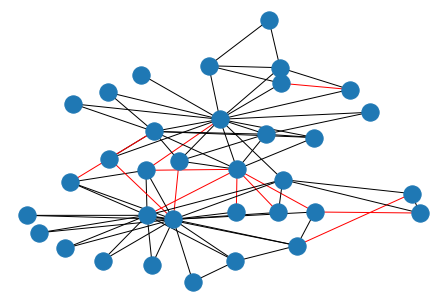

In [ ]:
nx.draw(G, pos=nx.kamada_kawai_layout(G), edge_color=edge_color)

In [ ]:
data = custom_data(skeleton)
FW = nx.floyd_warshall_numpy(skeleton)

In [ ]:
model = GCN([21, 14, 7])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2658, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1883, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.1198, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0752, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0647, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0547, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0491, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0455, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0435, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0420, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0408, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0399, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0390, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0381, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0372, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0364, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, skeleton, 50, 4, log=False))

Comparison score: 0.7101327561327565


In [ ]:
print('Projection score:', test_projection_l1(emb, skeleton, 50, 4, log=False))

Projection score: 0.9826580086580085


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, skeleton, 50, 4, log=False))

Comparison score: 0.7008091630591632
Comparison score: 0.7439725829725832
Comparison score: 0.7076010101010104
Comparison score: 0.6978787878787882
Comparison score: 0.695656565656566
Comparison score: 0.695656565656566


In [ ]:
for decimals in np.arange(1,7):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, skeleton, 50, 4, log=False))

Projection score: 0.7081150793650793
Projection score: 0.9528715728715725
Projection score: 0.9628802308802306
Projection score: 0.9628802308802306
Projection score: 0.9628802308802306
Projection score: 0.9628802308802306


## Presentation example

In [ ]:
def growth_draw(G, FW):
    S = {np.random.choice(G.nodes())}
    sz = [1 / len(G)]
    pos = nx.spring_layout(G)
    while len(S) < nx.number_of_nodes(G):
        p = []
        for v in G.nodes():
            if v in S:
                tmp = 0
            else:
                tmp = len(set(G.neighbors(v)).intersection(S))
            p.append(tmp)
        p = np.array(p)
        norm = np.linalg.norm(p, ord=1)
        if norm > 0:
            p = p / norm
        new_node = np.random.choice(G.nodes(), p=p)
        S.add(new_node)
        S = get_hull_fw_growth(G, FW, S)
        cmap=[]
        for i in G.nodes():
            if i in S:
                cmap.append('orange')
            else:
                cmap.append('#1f78b4')
        plt.figure()
        nx.draw(G, pos=pos, node_color=cmap)
        sz.append(len(S) / len(G))
    return sz

[0.029411764705882353,
 0.058823529411764705,
 0.11764705882352941,
 0.5,
 0.5294117647058824,
 0.5588235294117647,
 0.5882352941176471,
 0.6176470588235294,
 0.6470588235294118,
 0.6764705882352942,
 0.7647058823529411,
 0.7941176470588235,
 0.8235294117647058,
 0.8529411764705882,
 0.8823529411764706,
 0.9117647058823529,
 0.9411764705882353,
 0.9705882352941176,
 1.0]

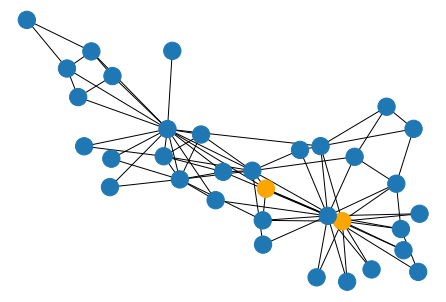

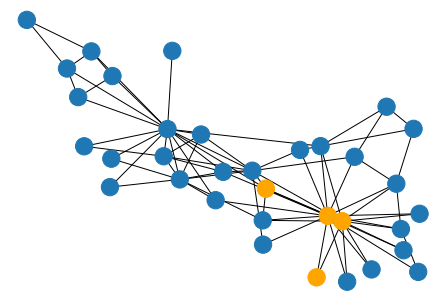

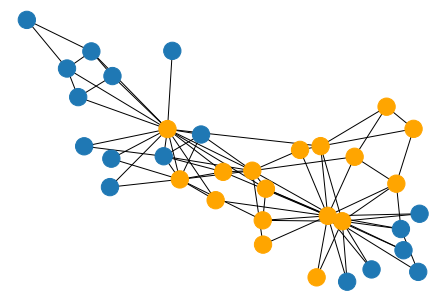

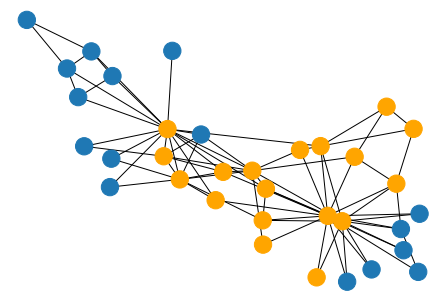

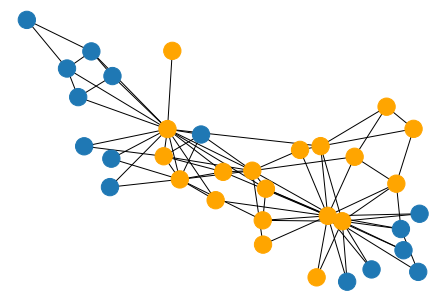

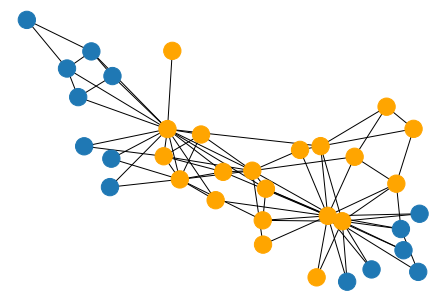

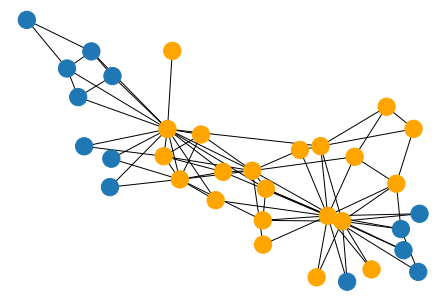

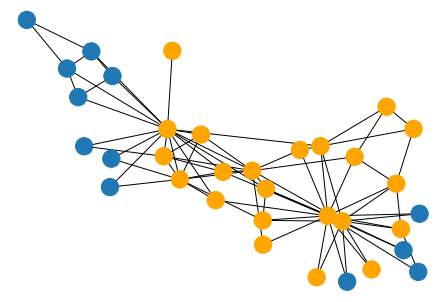

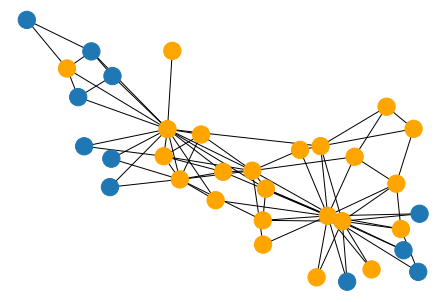

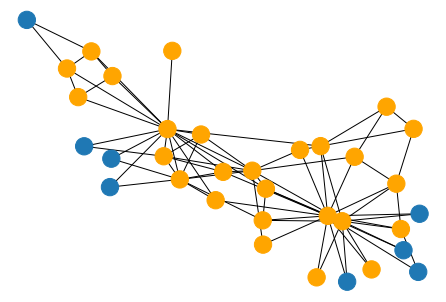

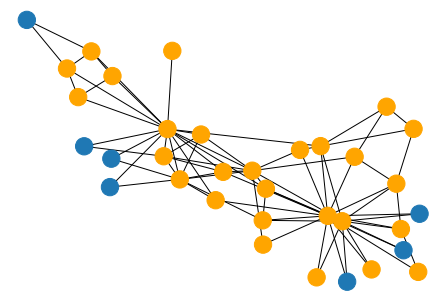

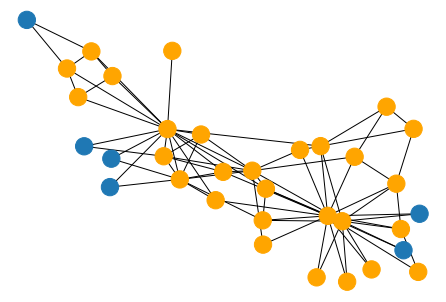

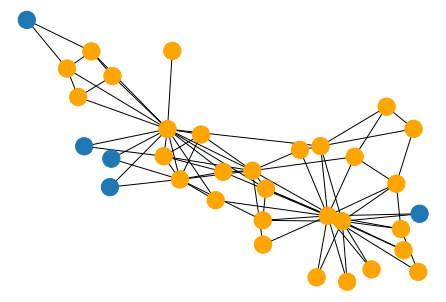

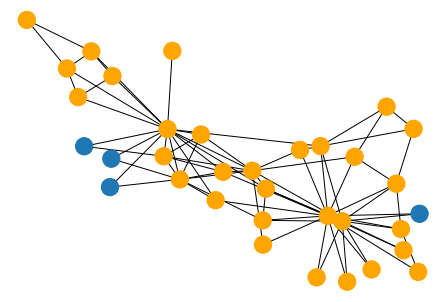

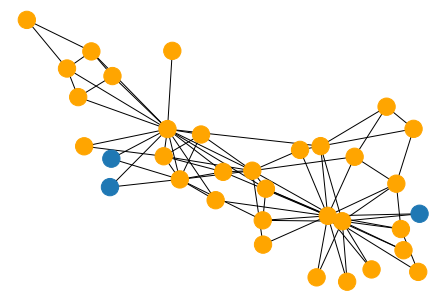

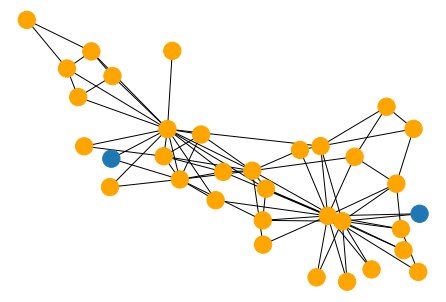

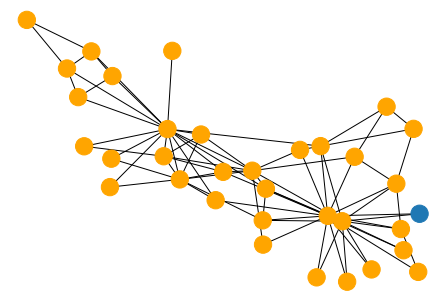

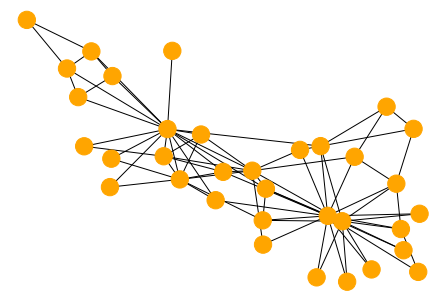

In [ ]:
growth_draw(G, FW)

## Configurational model

### Implementation

In [ ]:
def power_law(gamma,x_min=2,size=1000): #size - размер массива
    x=np.zeros(size,dtype=int)
    for i in range(size):
        r=np.random.random()
        x[i]=int(x_min*np.float_power((r),1/(-gamma+1)))
    return x

In [ ]:
def simple_config_model(size, gamma, seed=42):
    degrees = power_law(gamma, size=size)
    if np.sum(degrees) % 2 != 0:
        degrees[0] += 1
    
    model = nx.configuration_model(degrees, seed=seed)
    model_simple = nx.Graph()
    for u, v in model.edges():
        if not model_simple.has_edge(u, v):
            model_simple.add_edge(u, v)
    return model_simple

In [ ]:
def plot_lin_degree_distribution(degrees):   
    rho=np.bincount(degrees)/len(degrees)
    k=np.arange(len(degrees))[np.nonzero(rho)]
    rho_k=rho[np.nonzero(rho)]

    plt.loglog()
    plt.scatter(k,rho_k)
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)

In [ ]:
def plot_log_degree_distribution(degrees, num_bins): 
    rho, k = np.histogram(degrees, bins=np.logspace(0, np.log10(np.max(degrees)), num_bins, endpoint=True), density=True)
    #k=np.arange(len(degrees))[np.nonzero(rho)]
    #rho_k=rho[np.nonzero(rho)]

    plt.scatter(k[:-1],rho)
    plt.loglog()
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)

### Test 100

In [ ]:
n = 100
gamma = 2
cG = simple_config_model(n, gamma)

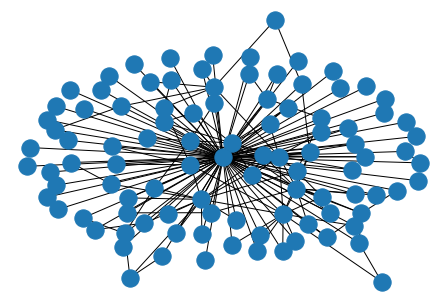

In [ ]:
nx.draw(cG)

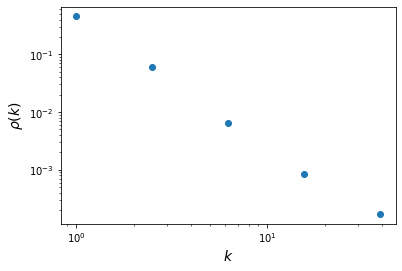

In [ ]:
plot_log_degree_distribution([d for node, d in cG.degree()], 6)

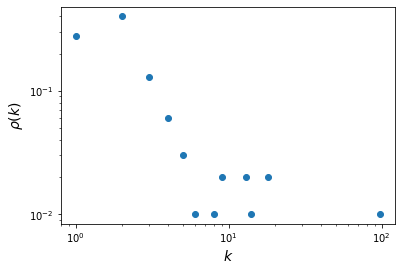

In [ ]:
plot_lin_degree_distribution([d for node, d in cG.degree()])

In [ ]:
nx.number_of_edges(cG)

196

In [ ]:
nx.number_of_nodes(cG)

100

In [ ]:
calculate_convexity(cG, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.7838999999999982

In [ ]:
nx.diameter(cG)

4

In [ ]:
data = custom_data(cG)
FW = nx.floyd_warshall_numpy(cG)

In [ ]:
model = GCN([20, 12])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0966, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0652, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0428, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0283, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0221, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0190, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0165, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0147, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0135, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0126, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0118, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0112, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0106, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0101, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0096, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0092, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, cG, 50, 2, log=False))

Comparison score: 0.6493333333333337


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, cG, 50, 2, log=False))

Comparison score: 0.5269393939393939
Comparison score: 0.662666666666667
Comparison score: 0.6493333333333337


In [ ]:
print('Projection score:', test_projection_l1(emb, cG, 50, 2, log=False))

Projection score: 0.99


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, cG, 50, 2, log=False))

Projection score: 0.7223549783549785
Projection score: 0.985
Projection score: 0.985


### Test 200

In [ ]:
n = 200
gamma = 2
cG = simple_config_model(n, gamma)

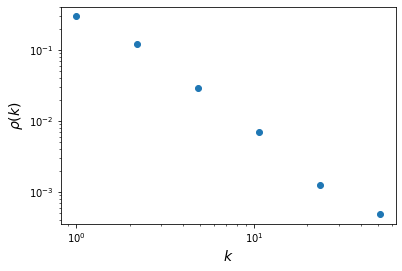

In [ ]:
plot_log_degree_distribution([d for node, d in cG.degree()], 7)

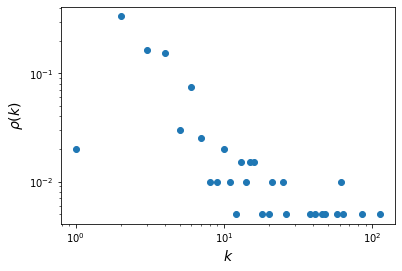

In [ ]:
plot_lin_degree_distribution([d for node, d in cG.degree()])

In [ ]:
nx.diameter(cG)

4

In [ ]:
data = custom_data(cG)
FW = nx.floyd_warshall_numpy(cG)

In [ ]:
model = GCN([26, 18])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1772, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.1205, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0803, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0541, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0403, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0330, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0285, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0258, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0239, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0223, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0210, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0198, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0188, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0178, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0170, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0162, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, cG, 50, 4, log=False))

Comparison score: 0.06616915695303373


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, cG, 50, 4, log=False))

Comparison score: 0.29985220640168725
Comparison score: 0.0842253340865956
Comparison score: 0.06871990589317883


# Barabasi-Albert

## BA 100

In [ ]:
n = 100
m = 3

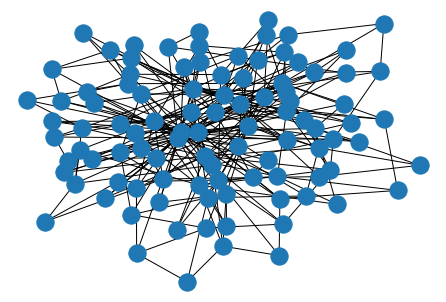

In [ ]:
BA = nx.barabasi_albert_graph(n, m, seed=42)
nx.draw(BA)

In [ ]:
nx.diameter(BA)

5

In [ ]:
data = custom_data(BA)
FW = nx.floyd_warshall_numpy(BA)

In [ ]:
model = GCN([20, 12])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1089, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0671, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0418, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0325, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0277, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0240, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0214, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0195, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0180, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0169, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0159, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0151, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0144, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0138, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0132, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0128, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, BA, 50, 4, log=False, debug=True))

[83 53 70 45]
[45, 53, 70, 83]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[79 37 65 54]
[1, 37, 54, 65, 79]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[48 28 85 83]
[28, 48, 83, 85]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 

In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, BA, 50, 4, log=False))

Comparison score: 0.2097734487734488
Comparison score: 0.05984473304473301
Comparison score: 0.053996248196248195


In [ ]:
print('Projection score:', test_projection_l1(emb, BA, 50, 2, log=False))

Projection score: 0.9952000000000001


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, BA, 50, 2, log=False))

Projection score: 0.771862683721507
Projection score: 0.9952000000000001
Projection score: 0.9952000000000001


In [ ]:
calculate_convexity(BA, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.07020000000000014

In [ ]:
nx.number_of_edges(BA)

291

In [ ]:
skeleton, removed_edges = get_convex_skeleton(BA, 72)

1 (78, 93)
2 (15, 90)
3 (11, 70)
4 (30, 38)
5 (30, 68)
6 (22, 40)
7 (35, 57)
8 (45, 53)
9 (45, 72)
10 (45, 73)
11 (45, 96)
12 (14, 32)
13 (27, 62)
14 (27, 78)
15 (18, 55)
16 (5, 47)
17 (0, 88)
18 (3, 77)
19 (4, 52)
20 (8, 24)
21 (25, 65)
22 (1, 36)
23 (39, 84)
24 (58, 87)
25 (67, 98)
26 (76, 86)
27 (10, 17)
28 (3, 74)
29 (4, 76)
30 (1, 46)
31 (10, 46)
32 (63, 67)
33 (13, 63)
34 (13, 41)
35 (4, 13)
36 (79, 91)
37 (9, 79)
38 (25, 86)
39 (11, 29)
40 (29, 67)
41 (14, 60)
42 (60, 89)
43 (18, 51)
44 (51, 80)
45 (25, 30)
46 (30, 58)
47 (1, 85)
48 (42, 85)
49 (34, 41)
50 (41, 81)
51 (9, 31)
52 (31, 97)
53 (22, 31)
54 (71, 82)
55 (71, 89)
56 (5, 71)
57 (9, 15)
58 (28, 34)
59 (28, 92)
60 (14, 23)
61 (23, 61)
62 (23, 81)
63 (14, 33)
64 (33, 37)
65 (33, 59)
66 (22, 69)
67 (69, 82)
68 (69, 99)
69 (0, 54)
70 (3, 54)
71 (18, 27)
72 (27, 43)


In [ ]:
calculate_convexity(skeleton, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.5229999999999968

In [ ]:
data = custom_data(skeleton)
FW = nx.floyd_warshall_numpy(skeleton)

In [ ]:
model = GCN([20, 12])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.1128, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0679, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0476, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0399, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0342, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0307, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0282, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0260, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0241, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0225, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0210, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0198, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0187, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0178, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0169, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0162, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, skeleton, 50, 4, log=False))

Comparison score: 0.11498804584653638


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, skeleton, 50, 4, log=False))

Comparison score: 0.2959965772687037
Comparison score: 0.13820037232900131
Comparison score: 0.12171454766477836


In [ ]:
print('Projection score:', test_projection_l1(emb, skeleton, 50, 4, log=False))

Projection score: 0.9280277750945555


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Projection score:', test_projection_l1(demb, skeleton, 50, 4, log=False))

Projection score: 0.6100800208897545
Projection score: 0.8799567233696648
Projection score: 0.9267762086785154


## BA 150

In [ ]:
n = 150
m = 3

In [ ]:
BA = nx.barabasi_albert_graph(n, m)

In [ ]:
nx.diameter(BA)

5

In [ ]:
data = custom_data(BA)
FW = nx.floyd_warshall_numpy(BA)

In [ ]:
model = GCN([27, 20, 13])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(3000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2639, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0395, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0312, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0256, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0221, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0200, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0185, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0174, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0166, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0158, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0151, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0145, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0139, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0134, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0129, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0125, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, BA, 50, 2, log=False))

Comparison score: 0.31918095238095245


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, BA, 50, 2, log=False))

Comparison score: 0.259825974025974
Comparison score: 0.3258476190476191
Comparison score: 0.31918095238095245


## BA 200

In [ ]:
n = 200
m = 3

In [ ]:
BA = nx.barabasi_albert_graph(n, m)

In [ ]:
nx.diameter(BA)

5

In [ ]:
data = custom_data(BA)
FW = nx.floyd_warshall_numpy(BA)

In [ ]:
model = GCN([27, 20, 13])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(3000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.2802, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0425, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0332, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0273, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0241, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0224, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0211, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0199, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0188, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0176, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0166, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0158, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0151, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0145, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0139, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0135, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, BA, 50, 2, log=False))

Comparison score: 0.32353333333333323


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, BA, 50, 2, log=False))

Comparison score: 0.2379017745031475
Comparison score: 0.3301999999999999
Comparison score: 0.32353333333333323


# Convexity structure

In [ ]:
G = nx.karate_club_graph()
FW = nx.floyd_warshall_numpy(G)

In [ ]:
h = get_hull_fw(G, FW, [0, 33])
h

[0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33]

In [ ]:
c = 0
for i, j in list(combinations(h, 2)):
    t = get_hull_fw(G, FW, [i, j])
    if t==h:
        c += 1
    print(i, j, t, FW[i, j])
print(c)

0 1 [0, 1] 1.0
0 2 [0, 2] 1.0
0 8 [0, 8] 1.0
0 9 [0, 9, 2] 2.0
0 13 [0, 13] 1.0
0 19 [0, 19] 1.0
0 23 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 24 [0, 24, 31] 2.0
0 25 [0, 25, 31] 2.0
0 27 [0, 2, 27] 2.0
0 28 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 30 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 31 [0, 31] 1.0
0 32 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 33 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 2 [1, 2] 1.0
1 8 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 9 [1, 2, 9] 2.0
1 13 [1, 13] 1.0
1 19 [1, 19] 1.0
1 23 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
1 24 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
1 25 [0, 1, 25, 31] 3.0
1 27 [1, 2, 27] 2.0
1 28 [1, 2, 28] 2.0
1 30 [1, 30] 1.0
1 31 [0, 1, 31] 2.0
1 32 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 33 [0, 1, 2, 8, 9, 13, 19, 23, 24,

In [ ]:
relation = nx.Graph()
for i, j in list(combinations(h, 2)):
    t = get_hull_fw(G, FW, [i, j])
    if t==h:
        relation.add_edge(i, j)

In [ ]:
for i in G.nodes():
    if i not in h:
        relation.add_node(i)

In [ ]:
complement = nx.Graph()
for i, j in list(combinations(h, 2)):
    if (i, j) in G.edges():
        complement.add_edge(i, j)
for i in G.nodes():
    if i not in h:
        complement.add_node(i)

In [ ]:
for i in G.nodes():
    if i in h:
        print(complement.degree()[i], relation.degree()[i])

6 5
5 5
8 5
5 9
2 7
4 10
3 6
4 3
3 6
3 5
4 5
3 6
4 5
6 4
6 6
10 3


In [ ]:
pos = nx.spring_layout(G, seed=42)

In [ ]:
cmap=[]
for i in relation.nodes():
    if i in h:
        cmap.append('orange')
    else:
        cmap.append('#1f78b4')

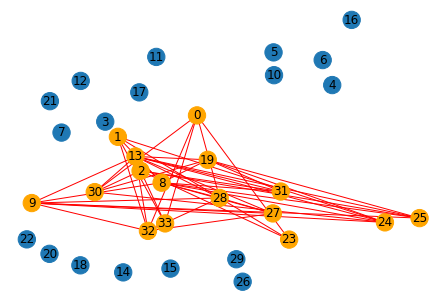

In [ ]:
nx.draw(relation, with_labels=True, pos=pos, node_color=cmap, edge_color='red')

In [ ]:
cmap=[]
for i in G.nodes():
    if i in h:
        cmap.append('orange')
    else:
        cmap.append('#1f78b4')

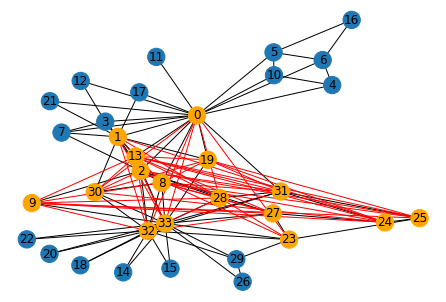

In [ ]:
nx.draw(G, with_labels=True, pos=pos, node_color=cmap)
nx.draw_networkx_edges(relation, pos=pos, edge_color='red')

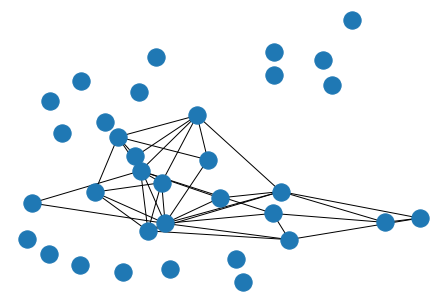

In [ ]:
nx.draw(complement, pos=pos)

In [ ]:
nx.number_of_edges(relation)

45

In [ ]:
s = 0
pairs = 0
for i, j in list(combinations(range(34), 2)):
    if not G.has_edge(i, j):
      t = get_hull_fw(G, FW, [i, j])
      s += len(t)
      pairs += 1
      print(i, j, t, FW[i, j])
s = s / pairs
print('Average convex hull size:', s)

0 9 [0, 9, 2] 2.0
0 14 [0, 1, 2, 8, 9, 13, 14, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 15 [0, 1, 2, 8, 9, 13, 15, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 16 [0, 16, 5, 6] 2.0
0 18 [0, 1, 2, 8, 9, 13, 18, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 20 [0, 1, 2, 8, 9, 13, 19, 20, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 22 [0, 1, 2, 8, 9, 13, 19, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 23 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 3.0
0 24 [0, 24, 31] 2.0
0 25 [0, 25, 31] 2.0
0 26 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] 3.0
0 27 [0, 2, 27] 2.0
0 28 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 29 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33] 3.0
0 30 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 32 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
0 33 [0, 1, 2, 8, 9, 13, 19, 23, 24, 25, 27, 28, 30, 31, 32, 33] 2.0
1 4 [0, 1, 4] 2.0
1 5 [0, 1, 5] 2.0
1

In [ ]:
skeleton, removed_edges = get_convex_skeleton(G, 12)

0 (23, 25)
1 (24, 27)
2 (2, 27)
3 (2, 28)
4 (19, 33)
5 (4, 10)
6 (1, 30)
7 (13, 33)
8 (0, 8)
9 (2, 8)
10 (2, 32)
11 (2, 9)


In [ ]:
s = 0
pairs = 0
FW = nx.floyd_warshall_numpy(skeleton)
for i, j in list(combinations(range(34), 2)):
    if not skeleton.has_edge(i, j):
        t = get_hull_fw(skeleton, FW, [i, j])
        s += len(t)
        pairs += 1
        print(i, j, t, FW[i, j])
s = s / pairs
print('Average convex hull size:', s)

0 8 [0, 32, 33, 8, 31] 3.0
0 9 [0, 9, 31, 33] 3.0
0 14 [0, 32, 33, 14, 31] 3.0
0 15 [0, 32, 33, 31, 15] 3.0
0 16 [0, 16, 5, 6] 2.0
0 18 [0, 32, 18, 33, 31] 3.0
0 20 [0, 32, 33, 20, 31] 3.0
0 22 [0, 32, 33, 22, 31] 3.0
0 23 [0, 32, 33, 23, 31] 3.0
0 24 [0, 24, 31] 2.0
0 25 [0, 25, 31] 2.0
0 26 [0, 33, 26, 31] 3.0
0 27 [0, 33, 27, 31] 3.0
0 28 [0, 28, 31] 2.0
0 29 [0, 32, 33, 29, 31] 3.0
0 30 [0, 32, 33, 30, 31] 3.0
0 32 [0, 32, 31] 2.0
0 33 [0, 33, 31] 2.0
1 4 [0, 1, 4] 2.0
1 5 [0, 1, 5] 2.0
1 6 [0, 1, 6] 2.0
1 8 [0, 1, 33, 32, 8, 31] 4.0
1 9 [0, 1, 33, 9, 31] 4.0
1 10 [0, 1, 10] 2.0
1 11 [0, 1, 11] 2.0
1 12 [0, 1, 3, 12] 2.0
1 14 [0, 1, 33, 32, 14, 31] 4.0
1 15 [0, 1, 33, 32, 31, 15] 4.0
1 16 [16, 1, 0, 5, 6] 3.0
1 18 [0, 1, 18, 33, 32, 31] 4.0
1 20 [0, 1, 33, 32, 20, 31] 4.0
1 22 [0, 1, 33, 32, 22, 31] 4.0
1 23 [0, 1, 33, 32, 23, 31] 4.0
1 24 [24, 1, 0, 31] 3.0
1 25 [0, 1, 25, 31] 3.0
1 26 [0, 1, 33, 26, 31] 4.0
1 27 [0, 1, 33, 27, 31] 4.0
1 28 [0, 1, 28, 31] 3.0
1 29 [0, 1, 33, 32, 2

# Trees

## Tree 50

In [ ]:
T = nx.random_tree(50)

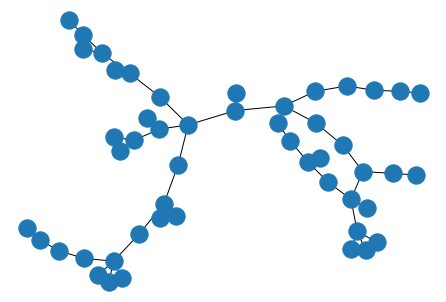

In [ ]:
nx.draw(T)

In [ ]:
nx.diameter(T)

18

In [ ]:
data = custom_data(T)
FW = nx.floyd_warshall_numpy(T)

In [ ]:
model = GCN([30, 20, 15, 10])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0969, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0418, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0270, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0171, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0121, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0098, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0084, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0075, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0070, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0066, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0063, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0061, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0059, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0058, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0057, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0056, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, T, 50, 4, log=False))

Comparison score: 0.4010310358865344


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, T, 50, 4, log=False))

Comparison score: 0.6219091451987182
Comparison score: 0.6371089369007324
Comparison score: 0.4355665225577728


## Tree 200

In [ ]:
T = nx.random_tree(200)

In [ ]:
nx.diameter(T)

52

In [ ]:
data = custom_data(T)
FW = nx.floyd_warshall_numpy(T)

In [ ]:
model = GCN([50, 30, 40, 20])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(5000):
    loss, emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0811, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0363, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0148, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0069, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0049, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0042, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0037, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0034, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0032, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0031, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0029, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0028, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0027, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0026, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0026, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0025, dtype=torch.float64, grad_fn=<Di

In [ ]:
emb = emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(emb, T, 50, 4, log=False))

Comparison score: 0.2263707261943153


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, T, 50, 4, log=False))

Comparison score: 0.2116512998500248
Comparison score: 0.6191602048119281
Comparison score: 0.35313314995911865


# Embedding to graph

## Implementation

In [ ]:
def emb_to_graph(emb):
    n = emb.shape[0]
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(n):
            if np.linalg.norm(emb[i] - emb[j], ord=1) == 1:
                G.add_edge(i, j)
    return G

In [ ]:
def ba_space(n, d):
    emb = np.zeros((n, d))
    emb[1][0] = 1
    free = [0, 1]
    degrees = [1, 1]
    occupied = {}
    occupied[tuple(emb[0])] = 0
    occupied[tuple(emb[1])] = 1
    i = 2
    while i < n:
        idx = np.random.choice(free, p=degrees / np.sum(degrees))
        neighbors = []
        for k in range(d):
            tmp = emb[idx].copy()
            tmp[k] -= 1
            if tuple(tmp) not in occupied:
                neighbors.append(-k)
            tmp = emb[idx].copy()
            tmp[k] += 1
            if tuple(tmp) not in occupied:
                neighbors.append(k)
        if len(neighbors) > 0:
            k = np.random.choice(neighbors)
            emb[i] = emb[idx]
            if k < 0:
                emb[i][-k] -= 1
            else:
                emb[i][k] += 1
            occupied[tuple(emb[i])] = i
            free.append(i)
            deg_i = 0
            for k in range(d):
                tmp = emb[i].copy()
                tmp[k] -= 1
                if tuple(tmp) in occupied:
                    deg_i += 1
                    degrees[occupied[tuple(tmp)]] += 1
                tmp = emb[i].copy()
                tmp[k] += 1
                if tuple(tmp) in occupied:
                    deg_i += 1
                    degrees[occupied[tuple(tmp)]] += 1
            degrees.append(deg_i)
            i += 1
    return emb

## Degree distribution

In [ ]:
BA = nx.barabasi_albert_graph(1000, 2)

In [ ]:
np.max([d for node, d in BA.degree()])

74

In [ ]:
emb = ba_space(1000, 40)

In [ ]:
V = emb_to_graph(emb)

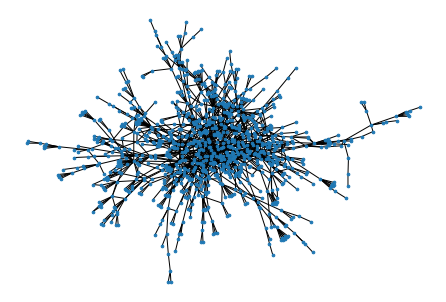

In [ ]:
nx.draw(V, node_size=7)

In [ ]:
degrees = [d for node, d in V.degree()]

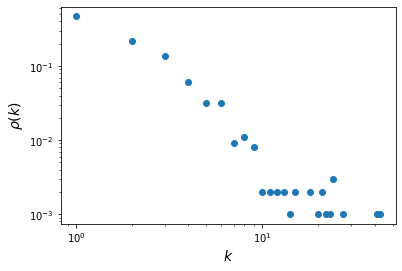

In [ ]:
plot_lin_degree_distribution(degrees)

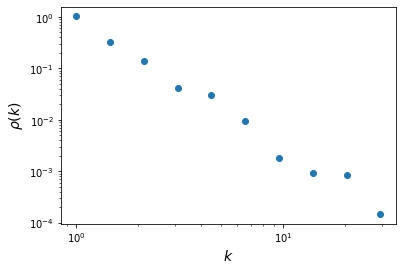

In [ ]:
plot_log_degree_distribution(degrees, 11)

## Test

In [ ]:
stats = {'degree:': [],
         'distance': [],
         'convexity': []}

In [ ]:
BA = nx.barabasi_albert_graph(100, 2)
np.max([d for node, d in BA.degree()])

29

In [ ]:
emb = ba_space(100, 15)

In [ ]:
V = emb_to_graph(emb)

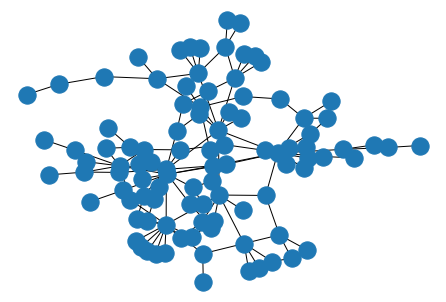

In [ ]:
nx.draw(V)

In [ ]:
degrees = [d for node, d in V.degree()]

In [ ]:
np.mean(degrees)

2.58

In [ ]:
np.mean(nx.floyd_warshall_numpy(V))

4.2992

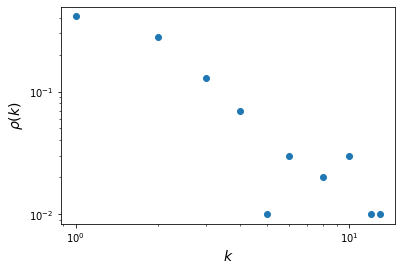

In [ ]:
plot_lin_degree_distribution(degrees)

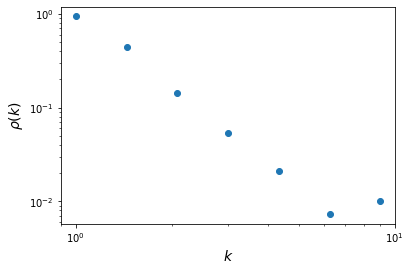

In [ ]:
plot_log_degree_distribution(degrees, 8)

In [ ]:
calculate_convexity(V, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.6899999999999983

In [ ]:
print('Comparison score:', test_comparison_l1(emb, V, 50, 4, log=False))

Comparison score: 0.7911852283101068


In [ ]:
nx.diameter(V)

10

In [ ]:
data = custom_data(V)
FW = nx.floyd_warshall_numpy(V)

In [ ]:
model = GCN([30, 21, 15])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(10000):
    loss, new_emb = gcn_train_l1(data)
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(0.0674, dtype=torch.float64, grad_fn=<DivBackward0>)
10 tensor(0.0304, dtype=torch.float64, grad_fn=<DivBackward0>)
20 tensor(0.0225, dtype=torch.float64, grad_fn=<DivBackward0>)
30 tensor(0.0186, dtype=torch.float64, grad_fn=<DivBackward0>)
40 tensor(0.0161, dtype=torch.float64, grad_fn=<DivBackward0>)
50 tensor(0.0145, dtype=torch.float64, grad_fn=<DivBackward0>)
60 tensor(0.0133, dtype=torch.float64, grad_fn=<DivBackward0>)
70 tensor(0.0124, dtype=torch.float64, grad_fn=<DivBackward0>)
80 tensor(0.0116, dtype=torch.float64, grad_fn=<DivBackward0>)
90 tensor(0.0109, dtype=torch.float64, grad_fn=<DivBackward0>)
100 tensor(0.0104, dtype=torch.float64, grad_fn=<DivBackward0>)
110 tensor(0.0100, dtype=torch.float64, grad_fn=<DivBackward0>)
120 tensor(0.0096, dtype=torch.float64, grad_fn=<DivBackward0>)
130 tensor(0.0093, dtype=torch.float64, grad_fn=<DivBackward0>)
140 tensor(0.0090, dtype=torch.float64, grad_fn=<DivBackward0>)
150 tensor(0.0087, dtype=torch.float64, grad_fn=<Di

In [ ]:
new_emb = new_emb.detach().numpy()

In [ ]:
print('Comparison score:', test_comparison_l1(new_emb, V, 50, 4, log=False))

Comparison score: 0.33659943882339227


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(new_emb, decimals)
    print('Comparison score:', test_comparison_l1(demb, V, 50, 4, log=False))

Comparison score: 0.4743515845850645
Comparison score: 0.6267691758855106
Comparison score: 0.40327409328455893


In [ ]:
print('Projection score:', test_projection_l1(new_emb, V, 50, 4, log=False))

Projection score: 1.0


In [ ]:
for decimals in np.arange(1,4):
    demb = discretize(new_emb, decimals)
    print('Projection score:', test_projection_l1(demb, V, 50, 4, log=False))

Projection score: 0.5272877350037296
Projection score: 0.99875
Projection score: 1.0


# Time comparison

In [ ]:
def naive_implementation(G, s):
    newfound = copy(set(s))
    temp = {1}  # whatever
    
    while len(temp) != 0:
        temp = set()
        for start, finish in list(combinations(newfound, 2)):  # remake to pairs (first set, second set)
            for path in list(nx.all_shortest_paths(G, start, finish)):
                for elem in path[1:-1]:
                    if elem not in temp and elem not in newfound:
                        temp.add(elem)
        newfound = newfound.union(temp)

    return list(newfound)

In [ ]:
rg50 = nx.generators.random_graphs.erdos_renyi_graph(50, 0.1)
fw50 = nx.floyd_warshall_numpy(rg50)
rg100 = nx.generators.random_graphs.erdos_renyi_graph(100, 0.1)
fw100 = nx.floyd_warshall_numpy(rg100)
rg150 = nx.generators.random_graphs.erdos_renyi_graph(150, 0.1)
fw150 = nx.floyd_warshall_numpy(rg150)
rg200 = nx.generators.random_graphs.erdos_renyi_graph(200, 0.1)
fw200 = nx.floyd_warshall_numpy(rg200)

## Base 2

[42, 47]
[37, 5]
[45, 25]
[15, 31]
[9, 40]
[10, 35]
[9, 4]
[1, 47]
[28, 12]
[44, 9]
[34, 73]
[37, 26]
[52, 6]
[11, 59]
[11, 75]
[91, 30]
[21, 18]
[90, 12]
[77, 80]
[63, 54]
[94, 145]
[51, 128]
[28, 78]
[51, 32]
[85, 143]
[12, 146]
[66, 42]
[83, 7]
[28, 135]
[48, 53]
[67, 129]
[167, 45]
[80, 52]
[132, 9]
[133, 58]
[182, 21]
[129, 60]
[88, 84]
[89, 64]
[144, 11]


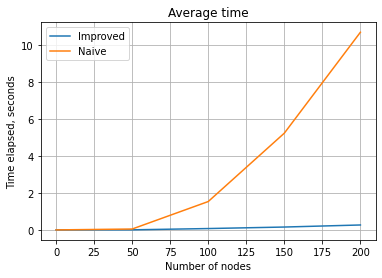

In [ ]:
fws = [fw50, fw100, fw150, fw200]
graphs = [rg50, rg100, rg150, rg200]

ourans = []
naiveans = []
for i in range(len(graphs)):
    bases = [list(np.random.choice(graphs[i].nodes(), 2, replace=False)) for _ in range(10)]

    ourtimes = []
    naivetimes = []
    for base in bases:
        print(base)
        t = time()
        ss = get_hull_fw(graphs[i], fws[i], base)
        ourtimes.append(time() - t)
        t = time()
        ss = naive_implementation(graphs[i], base)
        naivetimes.append(time() - t)
        #clear_output(True)
    ourans.append(ourtimes)
    naiveans.append(naivetimes)

f, ax = plt.subplots()
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in ourans], label='Improved')
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in naiveans], label='Naive')
ax.set_title('Average time')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Time elapsed, seconds')
ax.grid()
ax.legend()
plt.show()

## Base 3

[6, 45, 35]
[37, 9, 36]
[36, 6, 17]
[38, 18, 24]
[6, 43, 3]
[15, 38, 3]
[2, 43, 34]
[23, 21, 33]
[40, 17, 4]
[48, 11, 21]
[63, 54, 33]
[22, 37, 68]
[49, 37, 87]
[55, 84, 51]
[53, 64, 61]
[73, 7, 91]
[50, 35, 74]
[74, 8, 39]
[85, 52, 35]
[64, 10, 18]
[100, 16, 70]
[103, 115, 63]
[37, 71, 40]
[69, 34, 131]
[48, 144, 22]
[43, 49, 67]
[17, 65, 75]
[147, 76, 11]
[39, 57, 32]
[16, 107, 119]
[39, 94, 122]
[85, 162, 58]
[36, 167, 104]
[12, 163, 30]
[81, 142, 36]
[194, 59, 151]
[145, 176, 152]
[199, 8, 141]
[56, 69, 68]
[106, 25, 156]


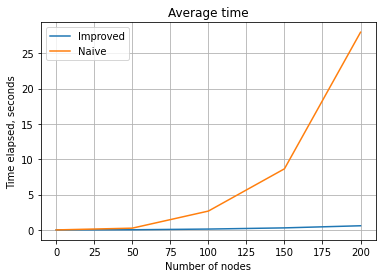

In [ ]:
fws = [fw50, fw100, fw150, fw200]
graphs = [rg50, rg100, rg150, rg200]

ourans = []
naiveans = []
for i in range(len(graphs)):
    bases = [list(np.random.choice(graphs[i].nodes(), 3, replace=False)) for _ in range(10)]

    ourtimes = []
    naivetimes = []
    for base in bases:
        print(base)
        t = time()
        ss = get_hull_fw(graphs[i], fws[i], base)
        ourtimes.append(time() - t)
        t = time()
        ss = naive_implementation(graphs[i], base)
        naivetimes.append(time() - t)
        #clear_output(True)
    ourans.append(ourtimes)
    naiveans.append(naivetimes)

f, ax = plt.subplots()
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in ourans], label='Improved')
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in naiveans], label='Naive')
ax.set_title('Average time')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Time elapsed, seconds')
ax.grid()
ax.legend()
plt.show()

## Base 4

[37, 34, 15, 41]
[17, 1, 40, 41]
[48, 25, 2, 17]
[33, 47, 2, 6]
[40, 9, 14, 5]
[26, 19, 7, 41]
[32, 10, 36, 45]
[13, 38, 2, 17]
[5, 28, 30, 12]
[24, 13, 7, 25]
[97, 15, 25, 56]
[89, 18, 6, 63]
[18, 3, 72, 56]
[96, 7, 60, 33]
[60, 28, 98, 96]
[9, 42, 28, 67]
[29, 87, 96, 34]
[26, 3, 72, 29]
[33, 21, 29, 69]
[17, 19, 48, 56]
[80, 91, 99, 117]
[80, 100, 118, 109]
[29, 25, 137, 4]
[144, 20, 147, 14]
[28, 37, 85, 61]
[6, 46, 32, 148]
[114, 123, 82, 1]
[10, 66, 46, 77]
[40, 93, 43, 15]
[29, 27, 65, 136]
[155, 98, 137, 96]
[160, 108, 22, 190]
[114, 123, 160, 93]
[20, 117, 58, 81]
[117, 76, 46, 44]
[36, 160, 97, 95]
[183, 141, 8, 158]
[193, 189, 131, 157]
[82, 49, 31, 118]
[167, 144, 12, 34]


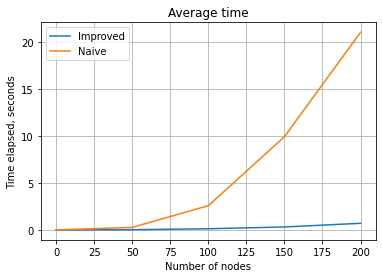

In [ ]:
fws = [fw50, fw100, fw150, fw200]
graphs = [rg50, rg100, rg150, rg200]

ourans = []
naiveans = []
for i in range(len(graphs)):
    bases = [list(np.random.choice(graphs[i].nodes(), 4, replace=False)) for _ in range(10)]

    ourtimes = []
    naivetimes = []
    for base in bases:
        print(base)
        t = time()
        ss = get_hull_fw(graphs[i], fws[i], base)
        ourtimes.append(time() - t)
        t = time()
        ss = naive_implementation(graphs[i], base)
        naivetimes.append(time() - t)
        #clear_output(True)
    ourans.append(ourtimes)
    naiveans.append(naivetimes)

f, ax = plt.subplots()
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in ourans], label='Improved')
plt.plot([0, 50, 100, 150, 200], [0] + [np.mean(t) for t in naiveans], label='Naive')
ax.set_title('Average time')
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Time elapsed, seconds')
ax.grid()
ax.legend()
plt.show()